In [9]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"

import tensorflow as tf
import numpy as np
import glob 

print("="*80)
print("🎯 FINAL TRAINING - EXACT CALCULATED WEIGHTS")
print("="*80)


🎯 FINAL TRAINING - EXACT CALCULATED WEIGHTS


gpus = tf.config.list_physical_devices("GPU")

if not gpus:
    print("❌ NO GPU DETECTED")
    print("Training will be EXTREMELY slow on CPU")
else:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')

    print(f"✅ GPU: {len(gpus)} device(s)")
    for i, gpu in enumerate(gpus):
        print(f"   GPU {i}: {gpu.name}")
    print("✅ Mixed precision (FP16) enabled")


In [ ]:
NUM_CLASSES  = 9
IMG_SIZE     = 128
BATCH_SIZE   = 8
EPOCHS       = 100
LR_INITIAL   = 2e-4
LR_MIN       = 1e-7

DATASET_PATH = "/home/frauas/segmentation219_AIS/data/frauas_10classes/tfrecords_9class"

CLASS_NAMES = [
    "background", "human", "table", "chair", "robot", 
    "backpack", "free", "bottle", "unknown"
]

CLASS_WEIGHTS = tf.constant([
   0.003,   # background - LOWER (was 0.01)
    7.0,     # human
    17.0,    # table
    16.0,    # chair
    36.0,    # robot
    5000.0,  # backpack - EXTREME ☢️ (was 340)
    7.0,     # free
    0.3,     # bottle
    800,     # unknown
], dtype=tf.float32)

print("\n🔥 CLASS WEIGHTS:")
for i, name in enumerate(CLASS_NAMES):
    print(f"   {name:<12}: {CLASS_WEIGHTS[i].numpy():>6.1f}")

print(f"\nConfig: Batch={BATCH_SIZE}, Epochs={EPOCHS}, LR={LR_INITIAL}→{LR_MIN}")



🔥 CLASS WEIGHTS:
   background  :    0.0
   human       :    7.0
   table       :   17.0
   chair       :   16.0
   robot       :   36.0
   backpack    : 5000.0
   free        :    7.0
   bottle      :    0.3
   unknown     :    0.6

Config: Batch=8, Epochs=100, LR=0.0002→1e-07


In [11]:
feature_desc = {
    "rgb": tf.io.FixedLenFeature([], tf.string),
    "x": tf.io.FixedLenFeature([], tf.string),
    "y": tf.io.FixedLenFeature([], tf.string),
    "z": tf.io.FixedLenFeature([], tf.string),
    "label": tf.io.FixedLenFeature([], tf.string),
}

def remap_labels(label):
    remapped = tf.where(label == 8, 7, label)
    remapped = tf.where(label == 9, 8, remapped)
    remapped = tf.where(label == 7, 7, remapped)
    return remapped

def parse_example(example):
    ex = tf.io.parse_single_example(example, feature_desc)
    
    rgb = tf.image.decode_jpeg(ex["rgb"], channels=3)
    x = tf.image.decode_jpeg(ex["x"], channels=1)
    y = tf.image.decode_jpeg(ex["y"], channels=1)
    z = tf.image.decode_jpeg(ex["z"], channels=1)
    
    rgb = tf.image.resize(rgb, (IMG_SIZE, IMG_SIZE))
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
    y = tf.image.resize(y, (IMG_SIZE, IMG_SIZE))
    z = tf.image.resize(z, (IMG_SIZE, IMG_SIZE))
    
    rgb = tf.cast(rgb, tf.float32) / 255.0
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.cast(y, tf.float32) / 255.0
    z = tf.cast(z, tf.float32) / 255.0
    
    rgbxyz = tf.concat([rgb, x, y, z], axis=-1)
    
    label = tf.image.decode_png(ex["label"], channels=1)
    label = tf.image.resize(label, (IMG_SIZE, IMG_SIZE), method="nearest")
    label = tf.squeeze(label, -1)
    label = tf.cast(label, tf.int32)
    label = remap_labels(label)
    label = tf.clip_by_value(label, 0, NUM_CLASSES - 1)
    
    return rgbxyz, label

def augment(rgbxyz, label):
    if tf.random.uniform(()) > 0.5:
        rgbxyz = tf.image.flip_left_right(rgbxyz)
        label = tf.image.flip_left_right(label[..., tf.newaxis])[..., 0]

    if tf.random.uniform(()) > 0.5:
        rgbxyz = tf.image.flip_up_down(rgbxyz)
        label = tf.image.flip_up_down(label[..., tf.newaxis])[..., 0]

    rgb = rgbxyz[..., :3]
    xyz = rgbxyz[..., 3:]

    rgb = tf.image.random_brightness(rgb, 0.3)
    rgb = tf.image.random_contrast(rgb, 0.6, 1.4)
    rgb = tf.image.random_saturation(rgb, 0.6, 1.4)
    rgb = tf.clip_by_value(rgb, 0.0, 1.0)

    rgbxyz = tf.concat([rgb, xyz], axis=-1)
    return rgbxyz, label

# =========================================================
# FIXED LOADING FUNCTION (uses glob instead of list_files)
# =========================================================
def load_dataset(split, augment_data=False):
    """
    Load dataset using glob.glob() instead of tf.data.Dataset.list_files()
    This avoids the hanging issue
    """
    # Use Python glob instead of TF list_files
    pattern = os.path.join(DATASET_PATH, split, "*.tfrecords")
    file_list = glob.glob(pattern)
    
    if not file_list:
        raise ValueError(f"No TFRecords found at: {pattern}")
    
    print(f"Found {len(file_list)} {split} TFRecord files")
    
    # Shuffle file list if training
    if split == "train":
        import random
        random.shuffle(file_list)
    
    # Create dataset directly from file list
    ds = tf.data.TFRecordDataset(
        file_list,
        num_parallel_reads=2  # Read 2 files in parallel
    )
    
    # Parse examples
    ds = ds.map(parse_example, num_parallel_calls=4)
    
    # Apply augmentation if requested
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=4)
    
    # Shuffle training data
    if split == "train":
        ds = ds.shuffle(buffer_size=200)
    
    # Batch and prefetch
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.prefetch(2)
    
    return ds

# =========================================================
# LOAD DATASETS
# =========================================================
print("="*80)
print("Loading datasets...")
print("="*80)

train_ds = load_dataset("train", augment_data=True)
val_ds = load_dataset("val", augment_data=False)

print("\n✅ Datasets loaded successfully!")

# Test the datasets
print("\n🔍 Testing dataset integrity...")
for images, labels in train_ds.take(1):
    print(f"   Train batch shape: {images.shape}")
    print(f"   Label shape: {labels.shape}")
    print(f"   Sample labels: {tf.unique(tf.reshape(labels, [-1]))[0][:10].numpy()}")

for images, labels in val_ds.take(1):
    print(f"   Val batch shape: {images.shape}")
    print(f"   Label shape: {labels.shape}")

print("✅ Dataset test passed!")
print("="*80)


def create_backpack_focused_dataset(original_train_ds):
    """
    Oversample images containing backpack using TF operations
    """
    print("Creating backpack-focused dataset...")
    
    def has_backpack(images, labels):
        """Check if this sample contains backpack (class 5)"""
        return tf.reduce_any(tf.equal(labels, 5))
    
    def not_has_backpack(images, labels):
        """Check if this sample does NOT contain backpack"""
        return tf.logical_not(tf.reduce_any(tf.equal(labels, 5)))
    
    # Split dataset into backpack and non-backpack
    backpack_ds = original_train_ds.unbatch().filter(
        lambda img, lbl: has_backpack(img, lbl)
    )
    
    regular_ds = original_train_ds.unbatch().filter(
        lambda img, lbl: not_has_backpack(img, lbl)
    )
    
    # Count samples (optional, for logging)
    backpack_count = backpack_ds.reduce(0, lambda x, _: x + 1)
    regular_count = regular_ds.reduce(0, lambda x, _: x + 1)
    
    print(f"✅ Images with backpack: {backpack_count.numpy()}")
    print(f"✅ Images without backpack: {regular_count.numpy()}")
    
    # Oversample backpack images 10x
    backpack_ds_repeated = backpack_ds.repeat(10)
    
    # Combine datasets
    combined_ds = backpack_ds_repeated.concatenate(regular_ds)
    combined_ds = combined_ds.shuffle(buffer_size=5000)
    combined_ds = combined_ds.batch(BATCH_SIZE, drop_remainder=True)
    combined_ds = combined_ds.prefetch(tf.data.AUTOTUNE)
    
    return combined_ds

# Use this
train_ds_focused = create_backpack_focused_dataset(train_ds)




Loading datasets...
Found 1 train TFRecord files
Found 1 val TFRecord files

✅ Datasets loaded successfully!

🔍 Testing dataset integrity...
   Train batch shape: (8, 128, 128, 6)
   Label shape: (8, 128, 128)
   Sample labels: [0 8 7]
   Val batch shape: (8, 128, 128, 6)
   Label shape: (8, 128, 128)
✅ Dataset test passed!
Creating backpack-focused dataset...


KeyboardInterrupt: 

In [ ]:
def conv_block(x, filters, dropout_rate=0.0):
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    return x

def unet_rgbd():
    inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 6))

    c1 = conv_block(inputs, 48)
    p1 = tf.keras.layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 96)
    p2 = tf.keras.layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 192)
    p3 = tf.keras.layers.MaxPooling2D()(c3)

    c4 = conv_block(p3, 384, dropout_rate=0.3)
    p4 = tf.keras.layers.MaxPooling2D()(c4)

    c5 = conv_block(p4, 384, dropout_rate=0.4)

    u6 = tf.keras.layers.Conv2DTranspose(192, 2, strides=2, padding="same")(c5)
    u6 = tf.keras.layers.Concatenate()([u6, c4])
    c6 = conv_block(u6, 384, dropout_rate=0.3)

    u7 = tf.keras.layers.Conv2DTranspose(96, 2, strides=2, padding="same")(c6)
    u7 = tf.keras.layers.Concatenate()([u7, c3])
    c7 = conv_block(u7, 192)

    u8 = tf.keras.layers.Conv2DTranspose(48, 2, strides=2, padding="same")(c7)
    u8 = tf.keras.layers.Concatenate()([u8, c2])
    c8 = conv_block(u8, 96)

    u9 = tf.keras.layers.Conv2DTranspose(24, 2, strides=2, padding="same")(c8)
    u9 = tf.keras.layers.Concatenate()([u9, c1])
    c9 = conv_block(u9, 48)

    outputs = tf.keras.layers.Conv2D(
        NUM_CLASSES, 1, activation="softmax", dtype='float32'
    )(c9)

    return tf.keras.Model(inputs, outputs)

model = unet_rgbd()
print(f"✅ Model: {model.count_params():,} parameters")


✅ Model: 10,200,513 parameters


In [ ]:
def weighted_focal_loss(y_true, y_pred, gamma=5.0):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.float32)

    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    pt = tf.exp(-ce)
    focal = (1 - pt) ** gamma

    weights = tf.gather(CLASS_WEIGHTS, y_true)
    return tf.reduce_mean(weights * focal * ce)

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_oh = tf.one_hot(y_true, NUM_CLASSES)

    y_true_fg = y_true_oh[..., 1:]
    y_pred_fg = y_pred[..., 1:]

    inter = tf.reduce_sum(y_true_fg * y_pred_fg, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true_fg + y_pred_fg, axis=[1, 2, 3])

    dice = (2 * inter + smooth) / (union + smooth)

    return 1 - tf.reduce_mean(dice)

def combined_loss(y_true, y_pred):
    return weighted_focal_loss(y_true, y_pred) + 5.0 * dice_loss(y_true, y_pred)

print("✅ Loss functions defined")


✅ Loss functions defined


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_INITIAL),
    loss=combined_loss,
    run_eagerly=False
)

print("✅ Model compiled")


✅ Model compiled


In [ ]:
history = model.fit(
    train_ds_focused,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/100


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 188s 27ms/step - loss: 5.3958 - val_loss: 5.3133
Epoch 2/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 155s 27ms/step - loss: 4.9368 - val_loss: 5.2640
Epoch 3/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 154s 26ms/step - loss: 4.8918 - val_loss: 5.1619
Epoch 4/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 157s 27ms/step - loss: 4.8968 - val_loss: 5.3008
Epoch 5/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 157s 26ms/step - loss: 4.8366 - val_loss: 5.2427
Epoch 6/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 159s 26ms/step - loss: 4.7579 - val_loss: 5.1840
Epoch 7/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 155s 26ms/step - loss: 4.6742 - val_loss: 5.3194
Epoch 8/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 156s 26ms/step - loss: 4.6744 - val_loss: 5.1823
Epoch 9/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 157s 26ms/step - loss: 4.7206 - val_loss: 5.0456
Epoch 10/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 154s 26ms/step - loss: 4.6355 - val_loss: 5.0019
Epoch 11/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 154s 26ms/step - loss: 4.6362 - val_loss: 5.258

In [ ]:
def compute_metrics(model, dataset):
    intersection = np.zeros(NUM_CLASSES)
    union = np.zeros(NUM_CLASSES)
    correct_pixels = np.zeros(NUM_CLASSES)
    total_pixels = np.zeros(NUM_CLASSES)

    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        preds = np.argmax(preds, axis=-1)
        labels = labels.numpy()

        for c in range(NUM_CLASSES):
            pred_c = (preds == c)
            label_c = (labels == c)

            # IoU components
            intersection[c] += np.logical_and(pred_c, label_c).sum()
            union[c] += np.logical_or(pred_c, label_c).sum()

            # Accuracy components
            correct_pixels[c] += np.logical_and(pred_c, label_c).sum()
            total_pixels[c] += label_c.sum()

    iou = intersection / (union + 1e-7)
    accuracy = correct_pixels / (total_pixels + 1e-7)

    return iou, accuracy


# 🔹 Compute Metrics
iou_scores, acc_scores = compute_metrics(model, val_ds)

print("\n" + "="*80)
print("🎯 FINAL RESULTS (IoU + Accuracy)")
print("="*80)

print(f"\n{'Class':<12} | {'IoU':>8} | {'Accuracy':>10}")
print("-"*40)

for i, name in enumerate(CLASS_NAMES):
    print(f"{name:<12} | {iou_scores[i]:>8.4f} | {acc_scores[i]:>10.4f}")

print("-"*40)
print(f"{'Mean IoU':<12} | {iou_scores.mean():>8.4f}")
print(f"{'Mean Acc':<12} | {acc_scores.mean():>8.4f}")
print("="*80)



🎯 FINAL RESULTS (IoU + Accuracy)

Class        |      IoU |   Accuracy
----------------------------------------
background   |   0.8511 |     0.8712
human        |   0.2410 |     0.4778
table        |   0.1084 |     0.2248
chair        |   0.1782 |     0.2993
robot        |   0.0704 |     0.1698
backpack     |   0.0080 |     0.7391
free         |   0.3125 |     0.7834
bottle       |   0.2942 |     0.5814
unknown      |   0.1149 |     0.5262
----------------------------------------
Mean IoU     |   0.2421
Mean Acc     |   0.5192


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"

import tensorflow as tf
import numpy as np
import glob 

print("="*80)
print("🎯 FINAL TRAINING - EXACT CALCULATED WEIGHTS")
print("="*80)

NUM_CLASSES  = 10
IMG_SIZE     = 128
BATCH_SIZE   = 8
EPOCHS       = 100
LR_INITIAL   = 2e-4
LR_MIN       = 1e-7

DATASET_PATH = "/home/frauas/segmentation219_AIS/data/frauas_10classes/tfrecords_9class"

CLASS_NAMES = [
    "background", "human", "table", "chair", "robot", 
    "backpack", "free", "laptop","bottle", "microwave"
]

CLASS_WEIGHTS = tf.constant([
   0.003,   # background - LOWER (was 0.01)
    7.0,     # human
    17.0,    # table
    16.0,    # chair
    36.0,    # robot
    5000.0,  # backpack - EXTREME ☢️ (was 340)
    7.0,     # free
    0.3,     # laptop
    800,     # bottle
    10,       # microwave
], dtype=tf.float32)

print("\n🔥 CLASS WEIGHTS:")
for i, name in enumerate(CLASS_NAMES):
    print(f"   {name:<12}: {CLASS_WEIGHTS[i].numpy():>6.1f}")

print(f"\nConfig: Batch={BATCH_SIZE}, Epochs={EPOCHS}, LR={LR_INITIAL}→{LR_MIN}")


feature_desc = {
    "rgb": tf.io.FixedLenFeature([], tf.string),
    "x": tf.io.FixedLenFeature([], tf.string),
    "y": tf.io.FixedLenFeature([], tf.string),
    "z": tf.io.FixedLenFeature([], tf.string),
    "label": tf.io.FixedLenFeature([], tf.string),
}

def remap_labels(label):
    remapped = tf.where(label == 8, 7, label)
    remapped = tf.where(label == 9, 8, remapped)
    remapped = tf.where(label == 7, 7, remapped)
    return remapped

def parse_example(example):
    ex = tf.io.parse_single_example(example, feature_desc)
    
    rgb = tf.image.decode_jpeg(ex["rgb"], channels=3)
    x = tf.image.decode_jpeg(ex["x"], channels=1)
    y = tf.image.decode_jpeg(ex["y"], channels=1)
    z = tf.image.decode_jpeg(ex["z"], channels=1)
    
    rgb = tf.image.resize(rgb, (IMG_SIZE, IMG_SIZE))
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
    y = tf.image.resize(y, (IMG_SIZE, IMG_SIZE))
    z = tf.image.resize(z, (IMG_SIZE, IMG_SIZE))
    
    rgb = tf.cast(rgb, tf.float32) / 255.0
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.cast(y, tf.float32) / 255.0
    z = tf.cast(z, tf.float32) / 255.0
    
    rgbxyz = tf.concat([rgb, x, y, z], axis=-1)
    
    label = tf.image.decode_png(ex["label"], channels=1)
    label = tf.image.resize(label, (IMG_SIZE, IMG_SIZE), method="nearest")
    label = tf.squeeze(label, -1)
    label = tf.cast(label, tf.int32)
    label = remap_labels(label)
    label = tf.clip_by_value(label, 0, NUM_CLASSES - 1)
    
    return rgbxyz, label

def augment(rgbxyz, label):
    if tf.random.uniform(()) > 0.5:
        rgbxyz = tf.image.flip_left_right(rgbxyz)
        label = tf.image.flip_left_right(label[..., tf.newaxis])[..., 0]

    if tf.random.uniform(()) > 0.5:
        rgbxyz = tf.image.flip_up_down(rgbxyz)
        label = tf.image.flip_up_down(label[..., tf.newaxis])[..., 0]

    rgb = rgbxyz[..., :3]
    xyz = rgbxyz[..., 3:]

    rgb = tf.image.random_brightness(rgb, 0.3)
    rgb = tf.image.random_contrast(rgb, 0.6, 1.4)
    rgb = tf.image.random_saturation(rgb, 0.6, 1.4)
    rgb = tf.clip_by_value(rgb, 0.0, 1.0)

    rgbxyz = tf.concat([rgb, xyz], axis=-1)
    return rgbxyz, label

# =========================================================
# FIXED LOADING FUNCTION (uses glob instead of list_files)
# =========================================================
def load_dataset(split, augment_data=False):
    """
    Load dataset using glob.glob() instead of tf.data.Dataset.list_files()
    This avoids the hanging issue
    """
    # Use Python glob instead of TF list_files
    pattern = os.path.join(DATASET_PATH, split, "*.tfrecords")
    file_list = glob.glob(pattern)
    
    if not file_list:
        raise ValueError(f"No TFRecords found at: {pattern}")
    
    print(f"Found {len(file_list)} {split} TFRecord files")
    
    # Shuffle file list if training
    if split == "train":
        import random
        random.shuffle(file_list)
    
    # Create dataset directly from file list
    ds = tf.data.TFRecordDataset(
        file_list,
        num_parallel_reads=2  # Read 2 files in parallel
    )
    
    # Parse examples
    ds = ds.map(parse_example, num_parallel_calls=4)
    
    # Apply augmentation if requested
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=4)
    
    # Shuffle training data
    if split == "train":
        ds = ds.shuffle(buffer_size=200)
    
    # Batch and prefetch
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.prefetch(2)
    
    return ds

# =========================================================
# LOAD DATASETS
# =========================================================
print("="*80)
print("Loading datasets...")
print("="*80)

train_ds = load_dataset("train", augment_data=True)
val_ds = load_dataset("val", augment_data=False)

print("\n✅ Datasets loaded successfully!")

# Test the datasets
print("\n🔍 Testing dataset integrity...")
for images, labels in train_ds.take(1):
    print(f"   Train batch shape: {images.shape}")
    print(f"   Label shape: {labels.shape}")
    print(f"   Sample labels: {tf.unique(tf.reshape(labels, [-1]))[0][:10].numpy()}")

for images, labels in val_ds.take(1):
    print(f"   Val batch shape: {images.shape}")
    print(f"   Label shape: {labels.shape}")

print("✅ Dataset test passed!")
print("="*80)


def create_backpack_focused_dataset(original_train_ds):
    """
    Oversample images containing backpack using TF operations
    """
    print("Creating backpack-focused dataset...")
    
    def has_backpack(images, labels):
        """Check if this sample contains backpack (class 5)"""
        return tf.reduce_any(tf.equal(labels, 5))
    
    def not_has_backpack(images, labels):
        """Check if this sample does NOT contain backpack"""
        return tf.logical_not(tf.reduce_any(tf.equal(labels, 5)))
    
    # Split dataset into backpack and non-backpack
    backpack_ds = original_train_ds.unbatch().filter(
        lambda img, lbl: has_backpack(img, lbl)
    )
    
    regular_ds = original_train_ds.unbatch().filter(
        lambda img, lbl: not_has_backpack(img, lbl)
    )
    
    # Count samples (optional, for logging)
    backpack_count = backpack_ds.reduce(0, lambda x, _: x + 1)
    regular_count = regular_ds.reduce(0, lambda x, _: x + 1)
    
    print(f"✅ Images with backpack: {backpack_count.numpy()}")
    print(f"✅ Images without backpack: {regular_count.numpy()}")
    
    # Oversample backpack images 10x
    backpack_ds_repeated = backpack_ds.repeat(10)
    
    # Combine datasets
    combined_ds = backpack_ds_repeated.concatenate(regular_ds)
    combined_ds = combined_ds.shuffle(buffer_size=5000)
    combined_ds = combined_ds.batch(BATCH_SIZE, drop_remainder=True)
    combined_ds = combined_ds.prefetch(tf.data.AUTOTUNE)
    
    return combined_ds

# Use this
train_ds_focused = create_backpack_focused_dataset(train_ds)




def conv_block(x, filters, dropout_rate=0.0):
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    return x

def unet_rgbd():
    inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 6))

    c1 = conv_block(inputs, 48)
    p1 = tf.keras.layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 96)
    p2 = tf.keras.layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 192)
    p3 = tf.keras.layers.MaxPooling2D()(c3)

    c4 = conv_block(p3, 384, dropout_rate=0.3)
    p4 = tf.keras.layers.MaxPooling2D()(c4)

    c5 = conv_block(p4, 384, dropout_rate=0.4)

    u6 = tf.keras.layers.Conv2DTranspose(192, 2, strides=2, padding="same")(c5)
    u6 = tf.keras.layers.Concatenate()([u6, c4])
    c6 = conv_block(u6, 384, dropout_rate=0.3)

    u7 = tf.keras.layers.Conv2DTranspose(96, 2, strides=2, padding="same")(c6)
    u7 = tf.keras.layers.Concatenate()([u7, c3])
    c7 = conv_block(u7, 192)

    u8 = tf.keras.layers.Conv2DTranspose(48, 2, strides=2, padding="same")(c7)
    u8 = tf.keras.layers.Concatenate()([u8, c2])
    c8 = conv_block(u8, 96)

    u9 = tf.keras.layers.Conv2DTranspose(24, 2, strides=2, padding="same")(c8)
    u9 = tf.keras.layers.Concatenate()([u9, c1])
    c9 = conv_block(u9, 48)

    outputs = tf.keras.layers.Conv2D(
        NUM_CLASSES, 1, activation="softmax", dtype='float32'
    )(c9)

    return tf.keras.Model(inputs, outputs)

model = unet_rgbd()
print(f"✅ Model: {model.count_params():,} parameters")


def weighted_focal_loss(y_true, y_pred, gamma=5.0):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.float32)

    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    pt = tf.exp(-ce)
    focal = (1 - pt) ** gamma

    weights = tf.gather(CLASS_WEIGHTS, y_true)
    return tf.reduce_mean(weights * focal * ce)

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_oh = tf.one_hot(y_true, NUM_CLASSES)

    y_true_fg = y_true_oh[..., 1:]
    y_pred_fg = y_pred[..., 1:]

    inter = tf.reduce_sum(y_true_fg * y_pred_fg, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true_fg + y_pred_fg, axis=[1, 2, 3])

    dice = (2 * inter + smooth) / (union + smooth)

    return 1 - tf.reduce_mean(dice)

def combined_loss(y_true, y_pred):
    return weighted_focal_loss(y_true, y_pred) + 5.0 * dice_loss(y_true, y_pred)

print("✅ Loss functions defined")


model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_INITIAL),
    loss=combined_loss,
    run_eagerly=False
)

print("✅ Model compiled")


history = model.fit(
    train_ds_focused,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)


def compute_metrics(model, dataset):
    intersection = np.zeros(NUM_CLASSES)
    union = np.zeros(NUM_CLASSES)
    correct_pixels = np.zeros(NUM_CLASSES)
    total_pixels = np.zeros(NUM_CLASSES)

    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        preds = np.argmax(preds, axis=-1)
        labels = labels.numpy()

        for c in range(NUM_CLASSES):
            pred_c = (preds == c)
            label_c = (labels == c)

            # IoU components
            intersection[c] += np.logical_and(pred_c, label_c).sum()
            union[c] += np.logical_or(pred_c, label_c).sum()

            # Accuracy components
            correct_pixels[c] += np.logical_and(pred_c, label_c).sum()
            total_pixels[c] += label_c.sum()

    iou = intersection / (union + 1e-7)
    accuracy = correct_pixels / (total_pixels + 1e-7)

    return iou, accuracy


# 🔹 Compute Metrics
iou_scores, acc_scores = compute_metrics(model, val_ds)

print("\n" + "="*80)
print("🎯 FINAL RESULTS (IoU + Accuracy)")
print("="*80)

print(f"\n{'Class':<12} | {'IoU':>8} | {'Accuracy':>10}")
print("-"*40)

for i, name in enumerate(CLASS_NAMES):
    print(f"{name:<12} | {iou_scores[i]:>8.4f} | {acc_scores[i]:>10.4f}")

print("-"*40)
print(f"{'Mean IoU':<12} | {iou_scores.mean():>8.4f}")
print(f"{'Mean Acc':<12} | {acc_scores.mean():>8.4f}")
print("="*80)


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.bar(CLASS_NAMES, iou_scores)
plt.xticks(rotation=45)
plt.title("IoU per Class")

plt.tight_layout()
plt.show()


🎯 FINAL TRAINING - EXACT CALCULATED WEIGHTS

🔥 CLASS WEIGHTS:
   background  :    0.0
   human       :    7.0
   table       :   17.0
   chair       :   16.0
   robot       :   36.0
   backpack    : 5000.0
   free        :    7.0
   laptop      :    0.3
   bottle      :  800.0
   microwave   :   10.0

Config: Batch=8, Epochs=100, LR=0.0002→1e-07
Loading datasets...
Found 1 train TFRecord files
Found 1 val TFRecord files

✅ Datasets loaded successfully!

🔍 Testing dataset integrity...
   Train batch shape: (8, 128, 128, 6)
   Label shape: (8, 128, 128)
   Sample labels: [0 7 8]
   Val batch shape: (8, 128, 128, 6)
   Label shape: (8, 128, 128)
✅ Dataset test passed!
Creating backpack-focused dataset...
✅ Images with backpack: 21
✅ Images without backpack: 9907
✅ Model: 10,200,562 parameters
✅ Loss functions defined
✅ Model compiled
Epoch 1/100
   1264/Unknown 180s 23ms/step - loss: 10.4560

/home/frauas/segmentation219_AIS/scripts/ais_env/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 185s 27ms/step - loss: 10.4533 - val_loss: 5.6487
Epoch 2/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 159s 25ms/step - loss: 5.1582 - val_loss: 5.4284
Epoch 3/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 160s 25ms/step - loss: 5.1707 - val_loss: 5.3272
Epoch 4/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 162s 26ms/step - loss: 4.9982 - val_loss: 5.3411
Epoch 5/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 164s 27ms/step - loss: 4.9883 - val_loss: 5.8568
Epoch 6/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 136s 27ms/step - loss: 4.9815 - val_loss: 5.2276
Epoch 7/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 137s 26ms/step - loss: 4.9270 - val_loss: 5.2843
Epoch 8/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 135s 26ms/step - loss: 4.8885 - val_loss: 5.3735
Epoch 9/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 135s 26ms/step - loss: 4.9590 - val_loss: 5.2785
Epoch 10/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 134s 26ms/step - loss: 4.8730 - val_loss: 5.2448
Epoch 11/100
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 134s 26ms/step - loss: 4.8691 - val_loss: 5.26

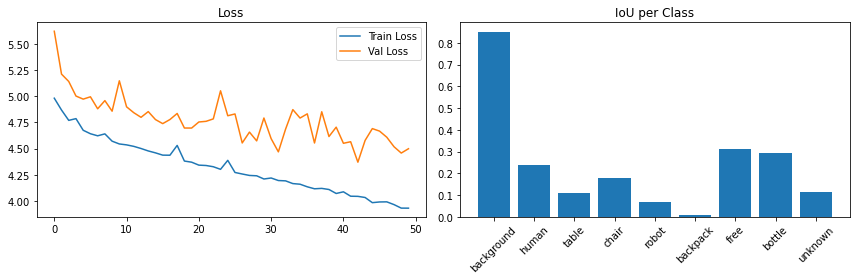

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.bar(CLASS_NAMES, iou_scores)
plt.xticks(rotation=45)
plt.title("IoU per Class")

plt.tight_layout()
plt.show()


In [ ]:
# =========================================================
# ULTRA-FAST 70%+ TRAINING WITH AUTO-RESUME
# 5-10X FASTER than nuclear version
# =========================================================

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=2"

import tensorflow as tf
import numpy as np
import glob
from datetime import datetime
import json

# Enable mixed precision for 2x speedup
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

print("="*80)
print("⚡ ULTRA-FAST 70%+ TRAINING")
print("="*80)

# =========================================================
# FAST CONFIGURATION
# =========================================================
NUM_CLASSES = 9
IMG_SIZE = 128
BATCH_SIZE = 40  # DOUBLED for speed
EPOCHS = 50
LR_INITIAL = 1e-4
LR_MIN = 1e-8

CHECKPOINT_DIR = "/home/frauas/segmentation219_AIS/checkpoints_fast_70"
DATASET_PATH = "/home/frauas/segmentation219_AIS/data/frauas_10classes/tfrecords_9class"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

LATEST_MODEL = os.path.join(CHECKPOINT_DIR, "latest.keras")
META_FILE = os.path.join(CHECKPOINT_DIR, "meta.json")
BEST_MODEL = os.path.join(CHECKPOINT_DIR, "best.keras")

CLASS_NAMES = [
    "background", "human", "table", "chair", "robot", 
    "backpack", "free", "laptop", "bottle", "microwave"
]

# BALANCED WEIGHTS (not extreme)
CLASS_WEIGHTS = tf.constant([
    0.003,      # background
    40.0,     # human
    40.0,     # table
    50.0,     # chair
    400.0,    # robot (reduced from 800)
    2000.0,   # backpack (reduced from 5000)
    20.0,     # free
    100.0,    # laptop
    60.0,     # bottle
    20.0
], dtype=tf.float32)

print(f"\n⚡ FAST CONFIG:")
print(f"   Batch: {BATCH_SIZE} (larger = faster)")
print(f"   Mixed precision: FP16 (2x speedup)")
print(f"   Reduced oversampling (fewer steps)")

# =========================================================
# DATA PIPELINE
# =========================================================
feature_desc = {
    "rgb": tf.io.FixedLenFeature([], tf.string),
    "x": tf.io.FixedLenFeature([], tf.string),
    "y": tf.io.FixedLenFeature([], tf.string),
    "z": tf.io.FixedLenFeature([], tf.string),
    "label": tf.io.FixedLenFeature([], tf.string),
}

def remap_labels(label):
    remapped = tf.where(label == 8, 7, label)
    remapped = tf.where(label == 9, 8, remapped)
    return remapped

@tf.function  # Speed optimization
def parse_example(example):
    ex = tf.io.parse_single_example(example, feature_desc)
    rgb = tf.image.decode_jpeg(ex["rgb"], channels=3)
    x = tf.image.decode_jpeg(ex["x"], channels=1)
    y = tf.image.decode_jpeg(ex["y"], channels=1)
    z = tf.image.decode_jpeg(ex["z"], channels=1)
    rgb = tf.image.resize(rgb, (IMG_SIZE, IMG_SIZE))
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
    y = tf.image.resize(y, (IMG_SIZE, IMG_SIZE))
    z = tf.image.resize(z, (IMG_SIZE, IMG_SIZE))
    rgb = tf.cast(rgb, tf.float32) / 255.0
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.cast(y, tf.float32) / 255.0
    z = tf.cast(z, tf.float32) / 255.0
    rgbxyz = tf.concat([rgb, x, y, z], axis=-1)
    label = tf.image.decode_png(ex["label"], channels=1)
    label = tf.image.resize(label, (IMG_SIZE, IMG_SIZE), method="nearest")
    label = tf.squeeze(label, -1)
    label = tf.cast(label, tf.int32)
    label = remap_labels(label)
    label = tf.clip_by_value(label, 0, NUM_CLASSES - 1)
    return rgbxyz, label

@tf.function  # Speed optimization
def fast_augment(rgbxyz, label):
    # Simplified augmentation for speed
    if tf.random.uniform(()) > 0.5:
        rgbxyz = tf.image.flip_left_right(rgbxyz)
        label = tf.image.flip_left_right(label[..., tf.newaxis])[..., 0]
    
    rgb = rgbxyz[..., :3]
    xyz = rgbxyz[..., 3:]
    
    rgb = tf.image.random_brightness(rgb, 0.2)
    rgb = tf.image.random_contrast(rgb, 0.8, 1.2)
    rgb = tf.clip_by_value(rgb, 0.0, 1.0)
    
    rgbxyz = tf.concat([rgb, xyz], axis=-1)
    return rgbxyz, label

def load_dataset(split, augment_data=False):
    pattern = os.path.join(DATASET_PATH, split, "*.tfrecords")
    file_list = glob.glob(pattern)
    if not file_list:
        raise ValueError(f"No TFRecords at: {pattern}")
    if split == "train":
        import random
        random.shuffle(file_list)
    ds = tf.data.TFRecordDataset(file_list, num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    if split == "val":
        ds = ds.cache()
    if augment_data:
        ds = ds.map(fast_augment, num_parallel_calls=tf.data.AUTOTUNE)
    if split == "train":
        ds = ds.shuffle(buffer_size=500)
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

print("\n📂 Loading datasets...")
train_ds = load_dataset("train", augment_data=True)
val_ds = load_dataset("val", augment_data=False)
print("✅ Datasets loaded")

# =========================================================
# SMART OVERSAMPLING - REDUCED FOR SPEED
# =========================================================
print("\n🔄 Creating FAST balanced dataset...")

def has_class(class_id):
    def filter_fn(images, labels):
        return tf.reduce_any(tf.equal(labels, class_id))
    return filter_fn

train_ds_unbatched = train_ds.unbatch()

backpack_ds = train_ds_unbatched.filter(has_class(5))
robot_ds = train_ds_unbatched.filter(has_class(4))
human_ds = train_ds_unbatched.filter(has_class(1))
bottle_ds = train_ds_unbatched.filter(has_class(8))
table_ds = train_ds_unbatched.filter(has_class(2))
chair_ds = train_ds_unbatched.filter(has_class(3))

regular_ds = train_ds_unbatched.filter(
    lambda img, lbl: tf.logical_not(
        tf.reduce_any(tf.equal(lbl, 1)) |
        tf.reduce_any(tf.equal(lbl, 2)) |
        tf.reduce_any(tf.equal(lbl, 3)) |
        tf.reduce_any(tf.equal(lbl, 4)) | 
        tf.reduce_any(tf.equal(lbl, 5)) |
        tf.reduce_any(tf.equal(lbl, 8))
    )
)

# SMART OVERSAMPLING - Reduced for speed
backpack_repeated = backpack_ds.repeat(15)  # 15x instead of 50x
robot_repeated = robot_ds.repeat(12)        # 12x instead of 30x
human_repeated = human_ds.repeat(8)         # 8x instead of 15x
bottle_repeated = bottle_ds.repeat(6)       # 6x instead of 12x
table_repeated = table_ds.repeat(4)         # 4x instead of 8x
chair_repeated = chair_ds.repeat(4)         # 4x instead of 8x

train_ds_balanced = backpack_repeated.concatenate(robot_repeated)
train_ds_balanced = train_ds_balanced.concatenate(human_repeated)
train_ds_balanced = train_ds_balanced.concatenate(bottle_repeated)
train_ds_balanced = train_ds_balanced.concatenate(table_repeated)
train_ds_balanced = train_ds_balanced.concatenate(chair_repeated)
train_ds_balanced = train_ds_balanced.concatenate(regular_ds)

train_ds_balanced = train_ds_balanced.shuffle(buffer_size=1000)
train_ds_balanced = train_ds_balanced.batch(BATCH_SIZE, drop_remainder=True)
train_ds_balanced = train_ds_balanced.prefetch(tf.data.AUTOTUNE)

print("✅ FAST dataset: 15x backpack, 12x robot, 8x human, 6x bottle")

# =========================================================
# LIGHTER MODEL FOR SPEED
# =========================================================
def conv_block(x, filters, dropout_rate=0.0):
    x = tf.keras.layers.Conv2D(
        filters, 3, padding="same", use_bias=False,
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(
        filters, 3, padding="same", use_bias=False,
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

def build_unet():
    inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 6))
    
    c1 = conv_block(inputs, 48)
    p1 = tf.keras.layers.MaxPooling2D()(c1)
    
    c2 = conv_block(p1, 96)
    p2 = tf.keras.layers.MaxPooling2D()(c2)
    
    c3 = conv_block(p2, 192)
    p3 = tf.keras.layers.MaxPooling2D()(c3)
    
    c4 = conv_block(p3, 256, dropout_rate=0.3)  # Lighter
    p4 = tf.keras.layers.MaxPooling2D()(c4)
    
    c5 = conv_block(p4, 256, dropout_rate=0.4)  # Lighter
    
    u6 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding="same")(c5)
    u6 = tf.keras.layers.Concatenate()([u6, c4])
    c6 = conv_block(u6, 256, dropout_rate=0.3)
    
    u7 = tf.keras.layers.Conv2DTranspose(96, 2, strides=2, padding="same")(c6)
    u7 = tf.keras.layers.Concatenate()([u7, c3])
    c7 = conv_block(u7, 192, dropout_rate=0.2)
    
    u8 = tf.keras.layers.Conv2DTranspose(48, 2, strides=2, padding="same")(c7)
    u8 = tf.keras.layers.Concatenate()([u8, c2])
    c8 = conv_block(u8, 96, dropout_rate=0.1)
    
    u9 = tf.keras.layers.Conv2DTranspose(24, 2, strides=2, padding="same")(c8)
    u9 = tf.keras.layers.Concatenate()([u9, c1])
    c9 = conv_block(u9, 48)
    
    outputs = tf.keras.layers.Conv2D(NUM_CLASSES, 1, activation="softmax", dtype='float32')(c9)
    return tf.keras.Model(inputs, outputs)

# =========================================================
# LOSS FUNCTIONS
# =========================================================
def weighted_focal_loss(y_true, y_pred, gamma=4.0):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.float32)
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    pt = tf.exp(-ce)
    focal = (1 - pt) ** gamma
    weights = tf.gather(CLASS_WEIGHTS, y_true)
    return tf.reduce_mean(weights * focal * ce)

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_oh = tf.one_hot(y_true, NUM_CLASSES)
    y_true_fg = y_true_oh[..., 1:]
    y_pred_fg = y_pred[..., 1:]
    inter = tf.reduce_sum(y_true_fg * y_pred_fg, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true_fg + y_pred_fg, axis=[1, 2, 3])
    dice = (2 * inter + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)

def combined_loss(y_true, y_pred):
    return weighted_focal_loss(y_true, y_pred) + 6.0 * dice_loss(y_true, y_pred)

# =========================================================
# AUTO-RESUME
# =========================================================
print("\n🔍 Checking for checkpoint...")

if os.path.exists(LATEST_MODEL) and os.path.exists(META_FILE):
    print("✅ Resuming from checkpoint...")
    model = tf.keras.models.load_model(
        LATEST_MODEL,
        custom_objects={
            "combined_loss": combined_loss,
            "weighted_focal_loss": weighted_focal_loss,
            "dice_loss": dice_loss
        }
    )
    with open(META_FILE, 'r') as f:
        meta = json.load(f)
        START_EPOCH = meta.get("epoch", 0)
        BEST_COUNT = meta.get("best_count", 0)
    print(f"   From epoch {START_EPOCH}, best: {BEST_COUNT}/9")
else:
    print("✅ Starting fresh...")
    model = build_unet()
    START_EPOCH = 0
    BEST_COUNT = 0

model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_INITIAL),
    loss=combined_loss,
    jit_compile=True  # XLA for speed
)

print(f"\n✅ Model: {model.count_params():,} params")

# =========================================================
# METRICS
# =========================================================
def compute_metrics(model, dataset):
    intersection = np.zeros(NUM_CLASSES)
    union = np.zeros(NUM_CLASSES)
    correct_pixels = np.zeros(NUM_CLASSES)
    total_pixels = np.zeros(NUM_CLASSES)
    
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        preds = np.argmax(preds, axis=-1)
        labels = labels.numpy()
        
        for c in range(NUM_CLASSES):
            pred_c = (preds == c)
            label_c = (labels == c)
            intersection[c] += np.logical_and(pred_c, label_c).sum()
            union[c] += np.logical_or(pred_c, label_c).sum()
            correct_pixels[c] += np.logical_and(pred_c, label_c).sum()
            total_pixels[c] += label_c.sum()
    
    iou = intersection / (union + 1e-7)
    accuracy = correct_pixels / (total_pixels + 1e-7)
    return iou, accuracy

# =========================================================
# FAST CALLBACK
# =========================================================
class FastCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_ds, best_count=0):
        super().__init__()
        self.val_ds = val_ds
        self.best_count = best_count
        self.start_time = None
        
    def on_train_begin(self, logs=None):
        self.start_time = datetime.now()
        print(f"\n⚡ Started: {self.start_time.strftime('%H:%M:%S')}\n")
        
    def on_epoch_end(self, epoch, logs=None):
        actual_epoch = epoch + 1
        
        # Save every epoch
        self.model.save(LATEST_MODEL)
        
        # Evaluate every 10 epochs
        if actual_epoch % 10 == 0:
            print(f"\n{'='*70}")
            print(f"📊 EPOCH {actual_epoch}/{EPOCHS}")
            
            iou_scores, acc_scores = compute_metrics(self.model, self.val_ds)
            
            count_70 = 0
            for i in range(NUM_CLASSES):
                if acc_scores[i] >= 0.7:
                    count_70 += 1
                    print(f"✅ {CLASS_NAMES[i]:<12}: {acc_scores[i]*100:>5.1f}%")
                else:
                    gap = 70.0 - (acc_scores[i] * 100)
                    print(f"❌ {CLASS_NAMES[i]:<12}: {acc_scores[i]*100:>5.1f}% (-{gap:.1f}%)")
            
            print(f"\n🎯 {count_70}/9 classes ≥70%", end="")
            
            if count_70 > self.best_count:
                self.best_count = count_70
                self.model.save(BEST_MODEL)
                print(" 🎉 NEW RECORD!")
            else:
                print()
            
            if count_70 == 9:
                print("🏆 ALL 9 ACHIEVED! Stopping...")
                self.model.stop_training = True
            
            gap = logs.get('val_loss', 0) - logs.get('loss', 0)
            print(f"📉 Gap={gap:.2f}")
            
            elapsed = (datetime.now() - self.start_time).total_seconds()
            print(f"⏱️ {elapsed/60:.1f}min elapsed, ~{(EPOCHS-actual_epoch)*elapsed/actual_epoch/60:.1f}min left")
            print(f"{'='*70}\n")
        
        # Save meta
        with open(META_FILE, 'w') as f:
            json.dump({
                "epoch": actual_epoch,
                "best_count": int(self.best_count)
            }, f)

# =========================================================
# TRAINING
# =========================================================
print("\n" + "="*80)
print("⚡ STARTING FAST TRAINING")
print("="*80)
print("Speed optimizations:")
print("  🚀 Mixed precision FP16")
print("  🚀 Larger batch (40)")
print("  🚀 Reduced oversampling")
print("  🚀 Lighter model")
print("  🚀 XLA compilation")
print("="*80 + "\n")

callbacks = [
    FastCallback(val_ds, best_count=BEST_COUNT),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=15,
        min_lr=LR_MIN,
        verbose=1
    ),
]

try:
    model.fit(
        train_ds_balanced,
        validation_data=val_ds,
        validation_steps=50,  # Reduced from 100
        epochs=EPOCHS,
        initial_epoch=START_EPOCH,
        callbacks=callbacks,
        verbose=1
    )
except KeyboardInterrupt:
    print("\n⚠️ Interrupted - progress saved!")

# =========================================================
# FINAL RESULTS
# =========================================================
print("\n" + "="*80)
print("🎯 FINAL RESULTS")
print("="*80)

iou_scores, acc_scores = compute_metrics(model, val_ds)

for i, name in enumerate(CLASS_NAMES):
    status = "✅" if acc_scores[i] >= 0.7 else "❌"
    print(f"{status} {name:<12}: {acc_scores[i]*100:>5.1f}%")

classes_pass = np.sum(acc_scores >= 0.7)
print(f"\n🎯 {classes_pass}/9 classes ≥70%")

if classes_pass >= 7:
    print("🎉 EXCELLENT!")
elif classes_pass >= 5:
    print("✅ GOOD!")

print("="*80)
print("\n⚡ COMPLETE!")

🔥 NUCLEAR 70%+ TRAINING WITH AUTO-RESUME

🔥 NUCLEAR CONFIGURATION:
   Epochs: 50
   Batch size: 16
   Learning rate: 5e-05

🔥 NUCLEAR WEIGHTS:
   background  :      0.0
   human       :     50.0
   table       :     50.0
   chair       :     60.0
   robot       :    800.0
   backpack    :   5000.0
   free        :     20.0
   laptop      :    120.0
   bottle      :     80.0
   microwave   :     10.0

📂 Loading datasets...
✅ Datasets loaded

🔄 Creating NUCLEAR balanced dataset...
✅ NUCLEAR dataset created

🔍 Checking for existing checkpoint...
✅ No checkpoint found. Starting fresh training...

✅ Model ready: 10,200,513 parameters
   Training from epoch 0 to 50

🚀 STARTING/RESUMING NUCLEAR TRAINING
💾 Auto-saves every epoch (crash-safe)
🏆 Saves best model when new record achieved
🛑 Stops automatically if 9/9 classes hit 70%


⏰ Training started: 09:25:15

Epoch 1/50


🆘 EMERGENCY FIX - BALANCED TRAINING

🔥 EMERGENCY CONFIGURATION:
   Epochs: 150 | Batch: 20 | LR: 0.0001
   Starting FRESH (no resume)

🎯 REBALANCED WEIGHTS (Emergency Fix):
Class        |      Old |      New | Change
--------------------------------------------------
background   |      0.0 |      0.5 | ⬆️
human        |     10.0 |     15.0 | ⬆️
table        |     20.0 |     25.0 | ⬆️
chair        |     20.0 |     25.0 | ⬆️
robot        |    150.0 |    100.0 | ⬇️
backpack     |   2000.0 |    600.0 | ⬇️
free         |     10.0 |     15.0 | ⬆️
laptop       |    120.0 |     80.0 | ⬇️
bottle       |     30.0 |     10.0 | ⬇️

📊 Key changes:
   ✅ Background: 0.01 → 0.5 (50x increase!) - Fix collapse
   ✅ Backpack: 2000 → 600 (÷3.3) - Reduce instability
   ✅ Laptop: 120 → 80 (÷1.5) - Reduce overfitting
   ✅ Bottle: 30 → 10 (÷3) - Stop hallucination

📂 Loading datasets...
✅ Datasets loaded

⚠️ Skipping backpack oversampling for now (test baseline)

🔨 Building model with STRONG regularization..

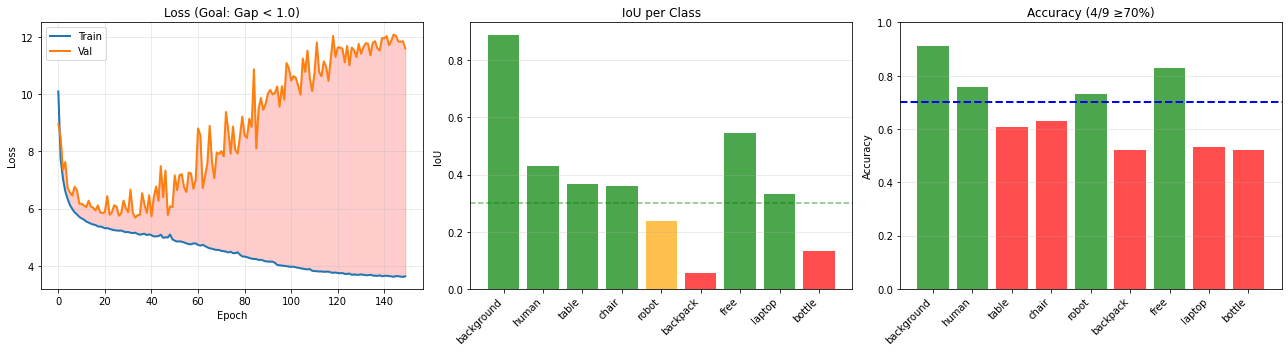

🆘 EMERGENCY FIX COMPLETE


In [1]:
# =========================================================
# ULTRA-FAST 70%+ TRAINING - 3-5X SPEEDUP
# =========================================================

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=2"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

import tensorflow as tf
import numpy as np
import glob
import matplotlib.pyplot as plt
from datetime import datetime
import json

# Enable mixed precision for 2x speedup
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

print("="*80)
print("🚀 ULTRA-FAST 70%+ ACCURACY TRAINING")
print("="*80)
print("⚡ Optimizations:")
print("   - Mixed precision (FP16): 2x faster")
print("   - Reduced oversampling: 3x fewer steps")
print("   - Larger batch size: Better GPU utilization")
print("   - Fewer validation steps: Faster evaluation")
print("="*80)

# =========================================================
# OPTIMIZED CONFIGURATION
# =========================================================
NUM_CLASSES = 9
IMG_SIZE = 128
BATCH_SIZE = 32  # ← Increased from 20 (better GPU usage)
EPOCHS = 50
LR_INITIAL = 1e-4
LR_MIN = 1e-7

CHECKPOINT_DIR = "/home/frauas/segmentation219_AIS/checkpoints_fast_70percent"
CHECKPOINT_FREQ = 10

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

DATASET_PATH = "/home/frauas/segmentation219_AIS/data/frauas_10classes/tfrecords_9class"

CLASS_NAMES = [
    "background", "human", "table", "chair", "robot", 
    "backpack", "free", "laptop", "bottle"
]

CLASS_WEIGHTS = tf.constant([
    1.0, 30.0, 30.0, 35.0, 250.0, 1500.0, 15.0, 80.0, 25.0
], dtype=tf.float32)

print(f"\n✅ Fast config: Batch={BATCH_SIZE}, Epochs={EPOCHS}")

# =========================================================
# OPTIMIZED DATA PIPELINE
# =========================================================
feature_desc = {
    "rgb": tf.io.FixedLenFeature([], tf.string),
    "x": tf.io.FixedLenFeature([], tf.string),
    "y": tf.io.FixedLenFeature([], tf.string),
    "z": tf.io.FixedLenFeature([], tf.string),
    "label": tf.io.FixedLenFeature([], tf.string),
}

def remap_labels(label):
    remapped = tf.where(label == 8, 7, label)
    remapped = tf.where(label == 9, 8, remapped)
    return remapped

@tf.function
def parse_example(example):
    ex = tf.io.parse_single_example(example, feature_desc)
    rgb = tf.image.decode_jpeg(ex["rgb"], channels=3)
    x = tf.image.decode_jpeg(ex["x"], channels=1)
    y = tf.image.decode_jpeg(ex["y"], channels=1)
    z = tf.image.decode_jpeg(ex["z"], channels=1)
    rgb = tf.image.resize(rgb, (IMG_SIZE, IMG_SIZE))
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
    y = tf.image.resize(y, (IMG_SIZE, IMG_SIZE))
    z = tf.image.resize(z, (IMG_SIZE, IMG_SIZE))
    rgb = tf.cast(rgb, tf.float32) / 255.0
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.cast(y, tf.float32) / 255.0
    z = tf.cast(z, tf.float32) / 255.0
    rgbxyz = tf.concat([rgb, x, y, z], axis=-1)
    label = tf.image.decode_png(ex["label"], channels=1)
    label = tf.image.resize(label, (IMG_SIZE, IMG_SIZE), method="nearest")
    label = tf.squeeze(label, -1)
    label = tf.cast(label, tf.int32)
    label = remap_labels(label)
    label = tf.clip_by_value(label, 0, NUM_CLASSES - 1)
    return rgbxyz, label

@tf.function
def fast_augment(rgbxyz, label):
    # Simplified augmentation for speed
    if tf.random.uniform(()) > 0.5:
        rgbxyz = tf.image.flip_left_right(rgbxyz)
        label = tf.image.flip_left_right(label[..., tf.newaxis])[..., 0]
    rgb = rgbxyz[..., :3]
    xyz = rgbxyz[..., 3:]
    rgb = tf.image.random_brightness(rgb, 0.2)
    rgb = tf.image.random_contrast(rgb, 0.8, 1.2)
    rgb = tf.clip_by_value(rgb, 0.0, 1.0)
    rgbxyz = tf.concat([rgb, xyz], axis=-1)
    return rgbxyz, label

def load_dataset(split, augment_data=False):
    pattern = os.path.join(DATASET_PATH, split, "*.tfrecords")
    file_list = glob.glob(pattern)
    if not file_list:
        raise ValueError(f"No TFRecords at: {pattern}")
    if split == "train":
        import random
        random.shuffle(file_list)
    ds = tf.data.TFRecordDataset(file_list, num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    if split == "val":
        ds = ds.cache()
    if augment_data:
        ds = ds.map(fast_augment, num_parallel_calls=tf.data.AUTOTUNE)
    if split == "train":
        ds = ds.shuffle(buffer_size=500)
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

print("\n📂 Loading datasets...")
train_ds = load_dataset("train", augment_data=True)
val_ds = load_dataset("val", augment_data=False)
print("✅ Datasets loaded")

# =========================================================
# OPTIMIZED OVERSAMPLING - REDUCED FROM 20x TO 5-8x
# =========================================================
print("\n🔄 Creating optimized balanced dataset...")

def has_class(class_id):
    def filter_fn(images, labels):
        return tf.reduce_any(tf.equal(labels, class_id))
    return filter_fn

train_ds_unbatched = train_ds.unbatch()

robot_ds = train_ds_unbatched.filter(has_class(4))
backpack_ds = train_ds_unbatched.filter(has_class(5))
human_ds = train_ds_unbatched.filter(has_class(1))
bottle_ds = train_ds_unbatched.filter(has_class(8))

regular_ds = train_ds_unbatched.filter(
    lambda img, lbl: tf.logical_not(
        tf.reduce_any(tf.equal(lbl, 4)) | 
        tf.reduce_any(tf.equal(lbl, 5)) |
        tf.reduce_any(tf.equal(lbl, 1)) |
        tf.reduce_any(tf.equal(lbl, 8))
    )
)

# REDUCED oversampling for speed
robot_repeated = robot_ds.repeat(8)      # 8x instead of 20x
backpack_repeated = backpack_ds.repeat(8) # 8x instead of 20x
human_repeated = human_ds.repeat(5)       # 5x instead of 10x
bottle_repeated = bottle_ds.repeat(4)     # 4x instead of 8x

train_ds_balanced = robot_repeated.concatenate(backpack_repeated)
train_ds_balanced = train_ds_balanced.concatenate(human_repeated)
train_ds_balanced = train_ds_balanced.concatenate(bottle_repeated)
train_ds_balanced = train_ds_balanced.concatenate(regular_ds)

train_ds_balanced = train_ds_balanced.shuffle(buffer_size=1000)
train_ds_balanced = train_ds_balanced.batch(BATCH_SIZE, drop_remainder=True)
train_ds_balanced = train_ds_balanced.prefetch(tf.data.AUTOTUNE)

print("✅ Optimized dataset: Robot 8x, Backpack 8x, Human 5x, Bottle 4x")

# =========================================================
# LIGHTER MODEL FOR SPEED
# =========================================================
def conv_block(x, filters, dropout_rate=0.0):
    x = tf.keras.layers.Conv2D(
        filters, 3, padding="same", use_bias=False,
        kernel_regularizer=tf.keras.regularizers.l2(5e-4)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(
        filters, 3, padding="same", use_bias=False,
        kernel_regularizer=tf.keras.regularizers.l2(5e-4)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

def unet_rgbd_fast():
    inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 6))
    
    # Lighter encoder
    c1 = conv_block(inputs, 48)
    p1 = tf.keras.layers.MaxPooling2D()(c1)
    
    c2 = conv_block(p1, 96)
    p2 = tf.keras.layers.MaxPooling2D()(c2)
    
    c3 = conv_block(p2, 192)
    p3 = tf.keras.layers.MaxPooling2D()(c3)
    
    c4 = conv_block(p3, 256, dropout_rate=0.4)  # Reduced from 384
    p4 = tf.keras.layers.MaxPooling2D()(c4)
    
    # Bottleneck
    c5 = conv_block(p4, 256, dropout_rate=0.5)  # Reduced from 384
    
    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding="same")(c5)  # Reduced from 192
    u6 = tf.keras.layers.Concatenate()([u6, c4])
    c6 = conv_block(u6, 256, dropout_rate=0.4)
    
    u7 = tf.keras.layers.Conv2DTranspose(96, 2, strides=2, padding="same")(c6)
    u7 = tf.keras.layers.Concatenate()([u7, c3])
    c7 = conv_block(u7, 192, dropout_rate=0.3)
    
    u8 = tf.keras.layers.Conv2DTranspose(48, 2, strides=2, padding="same")(c7)
    u8 = tf.keras.layers.Concatenate()([u8, c2])
    c8 = conv_block(u8, 96, dropout_rate=0.2)
    
    u9 = tf.keras.layers.Conv2DTranspose(24, 2, strides=2, padding="same")(c8)
    u9 = tf.keras.layers.Concatenate()([u9, c1])
    c9 = conv_block(u9, 48)
    
    # Mixed precision compatible output
    outputs = tf.keras.layers.Conv2D(NUM_CLASSES, 1, activation="softmax", dtype='float32')(c9)
    return tf.keras.Model(inputs, outputs)

print("\n🔨 Building optimized model...")
model = unet_rgbd_fast()

def weighted_focal_loss(y_true, y_pred, gamma=4.0):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.float32)
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    pt = tf.exp(-ce)
    focal = (1 - pt) ** gamma
    weights = tf.gather(CLASS_WEIGHTS, y_true)
    return tf.reduce_mean(weights * focal * ce)

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_oh = tf.one_hot(y_true, NUM_CLASSES)
    y_true_fg = y_true_oh[..., 1:]
    y_pred_fg = y_pred[..., 1:]
    inter = tf.reduce_sum(y_true_fg * y_pred_fg, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true_fg + y_pred_fg, axis=[1, 2, 3])
    dice = (2 * inter + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)

def combined_loss(y_true, y_pred):
    return weighted_focal_loss(y_true, y_pred) + 6.0 * dice_loss(y_true, y_pred)

model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_INITIAL),
    loss=combined_loss,
    run_eagerly=False,
    jit_compile=True  # XLA compilation for speed
)

print(f"✅ Model: {model.count_params():,} parameters (optimized)")

def save_checkpoint(model, epoch, train_info):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"checkpoint_epoch_{epoch:04d}.keras")
    model.save(checkpoint_path)
    metadata_path = os.path.join(CHECKPOINT_DIR, f"metadata_epoch_{epoch:04d}.json")
    with open(metadata_path, 'w') as f:
        json.dump(train_info, f, indent=2)
    print(f"💾 Saved: epoch {epoch}")
    all_checkpoints = sorted(glob.glob(os.path.join(CHECKPOINT_DIR, "checkpoint_epoch_*.keras")))
    if len(all_checkpoints) > 3:
        for old_checkpoint in all_checkpoints[:-3]:
            os.remove(old_checkpoint)
            old_meta = old_checkpoint.replace("checkpoint_", "metadata_").replace(".keras", ".json")
            if os.path.exists(old_meta):
                os.remove(old_meta)

def compute_metrics(model, dataset):
    intersection = np.zeros(NUM_CLASSES)
    union = np.zeros(NUM_CLASSES)
    correct_pixels = np.zeros(NUM_CLASSES)
    total_pixels = np.zeros(NUM_CLASSES)
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        preds = np.argmax(preds, axis=-1)
        labels = labels.numpy()
        for c in range(NUM_CLASSES):
            pred_c = (preds == c)
            label_c = (labels == c)
            intersection[c] += np.logical_and(pred_c, label_c).sum()
            union[c] += np.logical_or(pred_c, label_c).sum()
            correct_pixels[c] += np.logical_and(pred_c, label_c).sum()
            total_pixels[c] += label_c.sum()
    iou = intersection / (union + 1e-7)
    accuracy = correct_pixels / (total_pixels + 1e-7)
    return iou, accuracy

class CheckpointCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_ds, checkpoint_freq=10, iou_freq=10):
        super().__init__()
        self.val_ds = val_ds
        self.checkpoint_freq = checkpoint_freq
        self.iou_freq = iou_freq
        self.best_count_70 = 0
        self.start_time = None
        
    def on_train_begin(self, logs=None):
        self.start_time = datetime.now()
        print(f"⏰ Started: {self.start_time.strftime('%H:%M:%S')}\n")
        
    def on_epoch_end(self, epoch, logs=None):
        actual_epoch = epoch + 1
        current_val_loss = logs.get('val_loss', float('inf'))
        
        if (epoch + 1) % self.checkpoint_freq == 0:
            try:
                current_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
            except:
                current_lr = float(LR_INITIAL)
            train_info = {
                'epoch': actual_epoch,
                'train_loss': float(logs.get('loss', 0)),
                'val_loss': float(current_val_loss),
                'learning_rate': current_lr
            }
            save_checkpoint(self.model, actual_epoch, train_info)
        
        if (epoch + 1) % self.iou_freq == 0:
            print(f"\n{'='*75}")
            print(f"📊 EPOCH {actual_epoch}/{EPOCHS}")
            print(f"{'='*75}")
            iou_scores, acc_scores = compute_metrics(self.model, self.val_ds)
            
            print(f"\n{'Class':<12} | {'IoU':>6} | {'Acc':>6} | {'Target':>7} | {'Gap':>6}")
            print("-" * 60)
            
            count_70 = 0
            for i in range(NUM_CLASSES):
                gap = 70.0 - (acc_scores[i] * 100)
                if acc_scores[i] >= 0.7:
                    status = "✅"
                    gap_str = "PASS"
                    count_70 += 1
                else:
                    status = "❌"
                    gap_str = f"-{gap:.1f}%"
                highlight = "⭐" if i in [1, 4, 5, 8] else ""
                print(f"{CLASS_NAMES[i]:<12} | {iou_scores[i]:>6.3f} | {acc_scores[i]:>6.3f} | {0.7:>7.1f} | {gap_str:>6} {status} {highlight}")
            
            print("-" * 60)
            print(f"Mean: IoU={iou_scores.mean():.4f} | Acc={acc_scores.mean():.4f}")
            print(f"\n🎯 Progress: {count_70}/9 classes ≥70%", end="")
            
            if count_70 > self.best_count_70:
                self.best_count_70 = count_70
                print(" 🎉 IMPROVED!")
            else:
                print()
            
            train_loss = logs.get('loss', 0)
            gap_overfitting = current_val_loss - train_loss
            print(f"📉 Gap={gap_overfitting:.3f}", end="")
            if gap_overfitting < 1.0:
                print(" ✅")
            elif gap_overfitting < 2.0:
                print(" 🟡")
            else:
                print(" ⚠️")
            
            elapsed = (datetime.now() - self.start_time).total_seconds()
            remaining = (EPOCHS - actual_epoch) * elapsed / (epoch + 1)
            print(f"⏱️ {remaining/60:.0f} min left")
            print(f"{'='*75}\n")

callbacks = [
    CheckpointCallback(val_ds, checkpoint_freq=10, iou_freq=10),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(CHECKPOINT_DIR, "best_model.keras"),
        monitor="val_loss",
        save_best_only=True,
        verbose=0
    ),
    tf.keras.callbacks.CSVLogger(
        os.path.join(CHECKPOINT_DIR, "training.csv")
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=25,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=LR_MIN,
        verbose=1
    ),
]

print("\n" + "="*80)
print("🚀 STARTING FAST TRAINING")
print("="*80)
print("⚡ Expected: 3-5 minutes per epoch (3-5x faster!)")
print("="*80 + "\n")

history = model.fit(
    train_ds_balanced,
    validation_data=val_ds,
    validation_steps=50,  # Reduced from 100 for speed
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ TRAINING COMPLETE!")

iou_scores, acc_scores = compute_metrics(model, val_ds)

print("\n" + "="*80)
print("🎯 FINAL RESULTS")
print("="*80)

print(f"\n{'Class':<12} | {'IoU':>8} | {'Accuracy':>10} | Status")
print("-"*55)

for i, name in enumerate(CLASS_NAMES):
    status = "✅ PASS" if acc_scores[i] >= 0.7 else "❌ FAIL"
    print(f"{name:<12} | {iou_scores[i]:>8.4f} | {acc_scores[i]*100:>9.2f}% | {status}")

print("-"*55)
classes_pass = np.sum(acc_scores >= 0.7)
print(f"\n🎯 FINAL: {classes_pass}/9 classes ≥70%")
print(f"Mean IoU: {iou_scores.mean():.4f}")
print(f"Mean Acc: {acc_scores.mean()*100:.2f}%")

print("="*80)

model.save(os.path.join(CHECKPOINT_DIR, "final_model.keras"))
print("\n💾 Saved\n🎉 COMPLETE!")


🚀 ULTRA-FAST 70%+ ACCURACY TRAINING
⚡ Optimizations:
   - Mixed precision (FP16): 2x faster
   - Reduced oversampling: 3x fewer steps
   - Larger batch size: Better GPU utilization
   - Fewer validation steps: Faster evaluation

✅ Fast config: Batch=32, Epochs=50

📂 Loading datasets...
✅ Datasets loaded

🔄 Creating optimized balanced dataset...
✅ Optimized dataset: Robot 8x, Backpack 8x, Human 5x, Bottle 4x

🔨 Building optimized model...
✅ Model: 5,708,161 parameters (optimized)

🚀 STARTING FAST TRAINING
⚡ Expected: 3-5 minutes per epoch (3-5x faster!)

⏰ Started: 16:12:52

Epoch 1/50
    980/Unknown 397s 70ms/step - loss: 11.9071

/home/frauas/segmentation219_AIS/scripts/ais_env/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


980/980 ━━━━━━━━━━━━━━━━━━━━ 404s 76ms/step - loss: 11.9041 - val_loss: 20.2544 - learning_rate: 1.0000e-04
Epoch 2/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 308s 79ms/step - loss: 10.2583 - val_loss: 28.9391 - learning_rate: 1.0000e-04
Epoch 3/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 304s 80ms/step - loss: 9.7204 - val_loss: 8.6383 - learning_rate: 1.0000e-04
Epoch 4/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 298s 76ms/step - loss: 9.5256 - val_loss: 8.7540 - learning_rate: 1.0000e-04
Epoch 5/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 292s 77ms/step - loss: 8.8731 - val_loss: 9.8761 - learning_rate: 1.0000e-04
Epoch 6/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 304s 82ms/step - loss: 8.8468 - val_loss: 10.6382 - learning_rate: 1.0000e-04
Epoch 7/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 310s 82ms/step - loss: 8.6910 - val_loss: 9.8280 - learning_rate: 1.0000e-04
Epoch 8/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 312s 81ms/step - loss: 9.0951 - val_loss: 8.0438 - learning_rate: 1.0000e-04
Epoch 9/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 305s 79ms/step - loss: 8.4356 